In [48]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest,f_classif, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import *
import pickle

In [2]:
#Load data
resp = urlopen("https://s3.us-east-2.amazonaws.com/example.data/lacare_ml_challenge.zip")
zipfile = ZipFile(BytesIO(resp.read()))
df = pd.read_csv(zipfile.open('loan_data.csv'))

### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062952 entries, 0 to 1062951
Data columns (total 22 columns):
dti                           1062695 non-null float64
annual_inc                    1062952 non-null float64
delinq_2yrs                   712178 non-null float64
inq_last_6mths                1062951 non-null float64
open_acc                      1062952 non-null int64
pub_rec                       1062952 non-null int64
revol_bal                     1062952 non-null int64
revol_util                    1062299 non-null float64
total_acc                     1062952 non-null int64
out_prncp                     1062952 non-null int64
out_prncp_inv                 1062952 non-null int64
total_rec_late_fee            712178 non-null float64
collections_12_mths_ex_med    1062902 non-null float64
loan_status                   1062952 non-null object
purpose                       1062952 non-null object
home_ownership                1062952 non-null object
grade                   

The dataset has in total 1062952 records and 22 fields. Missing values exist in both numeric variables and categorical variables. We need to take a closer look later to come up stratigies to fill the missing values

First, let's check the target variable 'loan_status'

In [4]:
df.loan_status.value_counts()

Fully Paid     1041952
Charged Off      21000
Name: loan_status, dtype: int64

Since no missing value in the target and it is binary, we can transform the target to 1 when loan_status='charged off' and 0 when loan_status='Fully Paid'


In [5]:
df.loan_status=df.loan_status.apply(lambda x: 1 if x=='Charged Off' else 0)

##### Numeric Variables

In [6]:
df.describe()

,dti,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_rec_late_fee,collections_12_mths_ex_med,loan_status
count,1.062695e+06,1.062952e+06,712178.000000,1.062951e+06,1.062952e+06,1.062952e+06,1.062952e+06,1.062299e+06,1.062952e+06,1062952.0,1062952.0,7.121780e+05,1.062902e+06,1.062952e+06
mean,1.782664e+01,7.747530e+04,0.310125,6.314769e-01,1.152160e+01,2.083095e-01,1.643266e+04,5.123123e+01,2.507994e+01,0.0,0.0,8.745719e-01,1.590175e-02,1.975630e-02
std,1.081004e+01,7.077092e+04,0.863830,9.212500e-01,5.424619e+00,5.886361e-01,2.297172e+04,2.460178e+01,1.196763e+01,0.0,0.0,8.506289e+00,1.426574e-01,1.391618e-01
min,-1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.0,0.0,-1.800000e-09,0.000000e+00,0.000000e+00
25%,1.145000e+01,4.700000e+04,0.000000,0.000000e+00,8.000000e+00,0.000000e+00,5.939000e+03,3.270000e+01,1.600000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.714000e+01,6.500000e+04,0.000000,0.000000e+00,1.100000e+01,0.000000e+00,1.115200e+04,5.150000e+01,2.300000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.347000e+01,9.225000e+04,0.000000,1.000000e+00,1.400000e+01,0.000000e+00,1.989700e+04,7.020000e+01,3.200000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
max,9.990000e+02,1.099920e+07,39.000000,8.000000e+00,9.000000e+01,6.300000e+01,2.904836e+06,8.923000e+02,1.620000e+02,0.0,0.0,1.188830e+03,2.000000e+01,1.000000e+00


By checking the rough distributions of numeric variables, we learnt that 'out_prncp' and 'out_prncp_inv' are constant values across all records. I'm dropping them from the dataset. 

In [7]:
df.drop(['out_prncp','out_prncp_inv'],axis=1,inplace=True)

In [8]:
numeric=df.loc[:,df.select_dtypes([np.number]).columns]
#number of missing values for each numeric variable
numeric.isnull().sum()

dti                              257
annual_inc                         0
delinq_2yrs                   350774
inq_last_6mths                     1
open_acc                           0
pub_rec                            0
revol_bal                          0
revol_util                       653
total_acc                          0
total_rec_late_fee            350774
collections_12_mths_ex_med        50
loan_status                        0
dtype: int64

denlinq_2yrs, total_rec_late_fee,dti

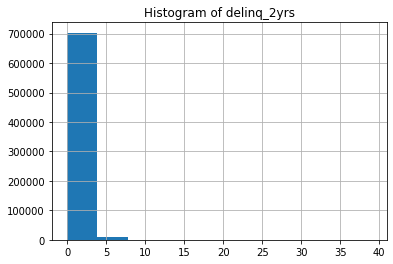

In [9]:
df.delinq_2yrs.hist()
plt.title('Histogram of delinq_2yrs')
plt.show()

Since 0 to 75th quantile are 0s, fill the missing delinq_2yrs with the median value 0

In [10]:
df.delinq_2yrs.fillna(df.delinq_2yrs.median(),inplace=True)

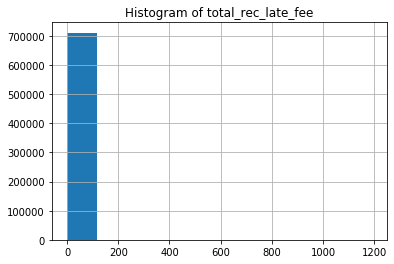

In [11]:
df.total_rec_late_fee.hist()
plt.title('Histogram of total_rec_late_fee')
plt.show()

Since most values of total_rec_late_fee are 0s, fill missing value with the median value 0

In [12]:
df.total_rec_late_fee.fillna(df.total_rec_late_fee.median(),inplace=True)

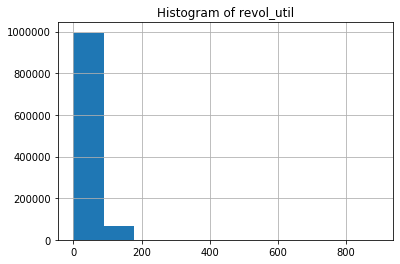

In [13]:
df.revol_util.hist()
plt.title('Histogram of revol_util')
plt.show()

revol_util is distributed with long tails on the right. It is better to fill missing value using median

In [14]:
df.revol_util.fillna(df.revol_util.median(),inplace=True)

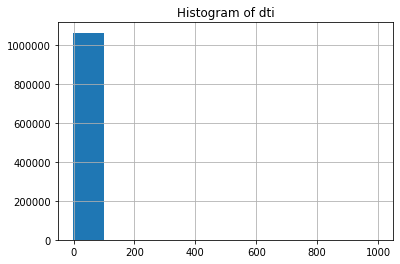

In [15]:
df.dti.hist()
plt.title('Histogram of dti')
plt.show()

dti has close median and mean, we can fill the missing with either mean or median.

In [16]:
df.dti.fillna(df.dti.median(),inplace=True)

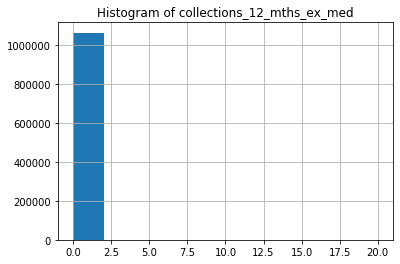

In [17]:
df.collections_12_mths_ex_med.hist()
plt.title('Histogram of collections_12_mths_ex_med')
plt.show()

collections_12_mths_ex_med also concentrated at 0, we can use median to fill the missing values

In [18]:
df.collections_12_mths_ex_med.fillna(df.collections_12_mths_ex_med.median(),inplace=True)



inq_last_6mths only has one missing value, fill the missing with median

In [19]:
df.inq_last_6mths.fillna(df.inq_last_6mths.median(),inplace=True)

Now we can check the heatmap for the numeric variables

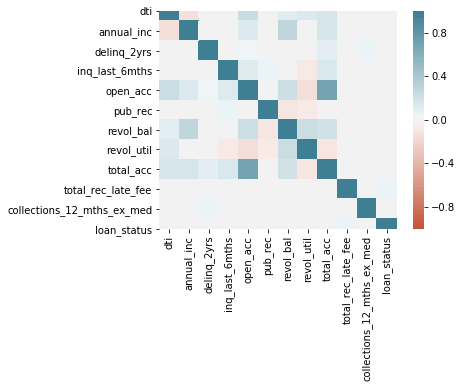

In [20]:
numeric=df.loc[:,df.select_dtypes([np.number]).columns]
corr=numeric.corr()

sns.heatmap(corr,
           vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()

Open_acc and total_acc shows high correlation, we can consider use just one of them in the modeling

##### Categorical Variables

In [21]:
category=df.loc[:,df.select_dtypes([np.object]).columns]
category.isnull().sum()

purpose                    0
home_ownership             0
grade                      0
emp_length             56734
term                       0
addr_state                 0
verification_status        0
application_type           0
dtype: int64

In [22]:
category.describe(include='all')

,purpose,home_ownership,grade,emp_length,term,addr_state,verification_status,application_type
count,1062952,1062952,1062952,1006218,1062952,1062952,1062952,1062952
unique,14,6,7,11,2,51,3,2
top,debt_consolidation,MORTGAGE,B,10+ years,36 months,CA,Source Verified,Individual
freq,609523,542808,333185,354124,842455,156310,405845,1044991


Only emp_length has missing values

In [23]:
category.emp_length.value_counts(dropna=False)

10+ years    354124
2 years       96256
3 years       84927
< 1 year      84637
1 year        69374
5 years       66839
4 years       63758
NaN           56734
6 years       50011
8 years       48258
7 years       47670
9 years       40364
Name: emp_length, dtype: int64

Fill missing strategy: add a column to indicate NaNs

Create dummies for categorical variables. Combine numeric and categorical variables to complete the data cleaning process.

In [24]:
cat_dummies=pd.get_dummies(category,dummy_na=True)
df.drop(category,axis=1,inplace=True)
data=pd.concat([df,cat_dummies],axis=1)

In [25]:
data.shape

(1062952, 116)

After data cleaning, the matrix size is [1062952*116]. To avoid the curse of dimensionality, we need to eliminate insignificant features to reduce input size goes into the model

### Feature Selection

In [26]:
X=data.drop(['loan_status'],axis=1)
y=data.loan_status


1. Remove clolumns with no variance

In [27]:
minvar=VarianceThreshold(threshold=0)
minvar.fit(X)
#dropped columns
drop_col=X.loc[:,minvar.get_support(indices=False)==False].columns
print(drop_col)
X.drop(drop_col,axis=1,inplace=True)

Index(['purpose_nan', 'home_ownership_nan', 'grade_nan', 'term_nan',
       'addr_state_nan', 'verification_status_nan', 'application_type_nan'],
      dtype='object')


2. Univariate Feature Selection

In [28]:
select1=SelectKBest(f_classif, k=30).fit(X,y)
select1_columns=X.columns[select1.get_support(indices=True)]


3. Feature Selection by logistic Model with L1 regularization

In [30]:
#Scale input features prepare for regression model
X_scale=pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)

#Logisitc regression with L1 regularization
cf=LogisticRegression(penalty='l1',n_jobs=-1,solver='saga').fit(X_scale,y)


/anaconda3/envs/python37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [31]:
select2=SelectFromModel(cf,prefit=True,max_features=30)
select2_columns=X.columns[select2.get_support(indices=True)]


4. Feauture Selection by ExtraTrees

In [32]:
cf_tree=ExtraTreesClassifier(n_estimators=200,n_jobs=-1).fit(X,y)
select3=SelectFromModel(cf_tree,prefit=True,max_features=30)
select3_columns=X.columns[select3.get_support(indices=True)]


Now, combine selected features from 3 methods

In [33]:
select_final=np.unique(np.concatenate((select1_columns,select2_columns,select3_columns)))
len(select_final)

35

35 features were selected for the model training

### Model Training

In [34]:
X=X.loc[:,select_final]

y.value_counts(normalize=True)

0    0.980244
1    0.019756
Name: loan_status, dtype: float64

Since the target is highly imbalanced, here his couple strategies to take:

1) oversampling 

2) stratified train test spliting

In [35]:
# oversampling 
oversample=RandomOverSampler(sampling_strategy=0.10,random_state=41)
X_res, y_res=oversample.fit_resample(X,y)

In [37]:
#stratified train test split
sp=StratifiedShuffleSplit(test_size=0.3,random_state=41)
for i,j in sp.split(X_res,y_res):
    train_index, test_index= i, j

train_X=X_res.loc[train_index,:]
test_X=X_res.loc[test_index,:]
train_y=y_res[train_index]
test_y=y_res[test_index]


Fit Model - Random forest


In [40]:
cf=RandomForestClassifier(n_estimators=200,oob_score=True,n_job=-1)
cf.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
cf.score(train_X,train_y)

1.0

In [41]:
cf.oob_score_

0.9973912566589638

The training dataset shows high accuary.
The high out of bag score is also close to 1 which proves the model is not overfitting

### Model performance

I'm checking the ROC-auc score and precision-recall curve to validate model performance

In [43]:
def plot_roc_curve(true,pred,label=None):
    fpr, tpr, thresholds = roc_curve(true,pred)
    score=roc_auc_score(true,pred)
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve: score= {0:0.4f}'.format(score))

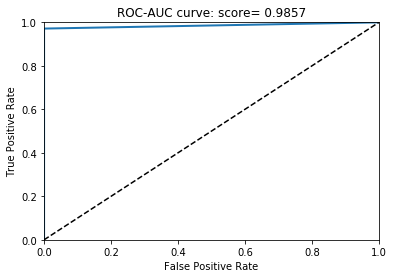

In [45]:
test_pred=cf.predict(test_X)
plot_roc_curve(test_y,test_pred)

In [46]:
def PRplot(true,pred):
    precision, recall, thresholds = precision_recall_curve(true,pred)
    average_precision = average_precision_score(true, pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall,precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision {0:0.4f}'.format(average_precision))

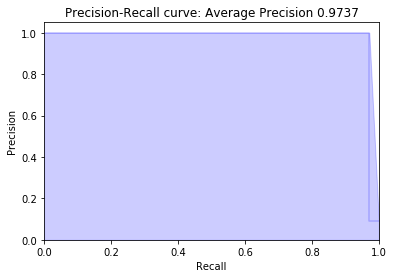

In [47]:
PRplot(test_y,test_pred)

#### Significant features

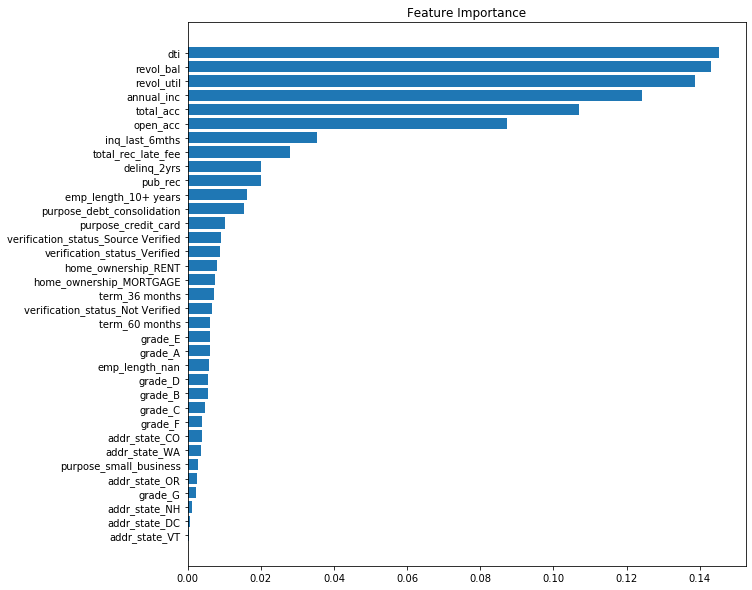

In [79]:
#get feature importances
importances=cf.feature_importances_

indices = np.argsort(importances)

names=[X.columns[i] for i in indices]
plt.figure(figsize=(10,10))
plt.barh(range(X.shape[1]),importances[indices])
plt.yticks(range(X.shape[1]),names)
plt.title('Feature Importance')
plt.show()


#### Conclusion: 
Both roc-auc curve and precision-recall curve indicate a good model performance on the test dataset. We can conclude this is a model to start with.

Strong predictors in the model are dti, revol_bal, revol_util, annual_inc, total_acc

With more time permitted, other models can be tried to further improve model performance, such as XGboost, Deep Learning CNN.

### Package Model for producition cycle

In [50]:
pickle.dump(cf,open('model.pkl','wb'))